In [19]:
import spacy
import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx

from summa import summarizer

from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.luhn import LuhnSummarizer
from sumy.summarizers.lex_rank import LexRankSummarizer
from sumy.summarizers.text_rank import TextRankSummarizer 

### Custom Implementation

In [2]:
nlp = spacy.load("en_core_web_md")
embed_model = SentenceTransformer("all-MiniLM-L6-v2")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [14]:
text = """\
In the late 20th century, the digital revolution transformed industries and societies, reshaping how people communicate, work, and consume media. This era saw the rise of personal computers, the internet, and mobile technology, each contributing to a more interconnected global community. The revolution not only enhanced data accessibility but also spurred significant innovations in software and hardware development. Companies like Microsoft and Apple became household names, driving forward technological advancements and changing everyday life. Despite its many benefits, this transformation also brought challenges, including privacy concerns and a digital divide that left certain populations behind. As the 21st century progresses, addressing these issues remains crucial to ensuring the digital revolution benefits all segments of society. I also like pizza."""

In [25]:
def get_sentences(text, spacy_pipeline):
    doc = spacy_pipeline(text)
    return [sent.text for sent in doc.sents]

In [26]:
sentences = get_sentences(text, nlp)
sentences

['In the late 20th century, the digital revolution transformed industries and societies, reshaping how people communicate, work, and consume media.',
 'This era saw the rise of personal computers, the internet, and mobile technology, each contributing to a more interconnected global community.',
 'The revolution not only enhanced data accessibility but also spurred significant innovations in software and hardware development.',
 'Companies like Microsoft and Apple became household names, driving forward technological advancements and changing everyday life.',
 'Despite its many benefits, this transformation also brought challenges, including privacy concerns and a digital divide that left certain populations behind.',
 'As the 21st century progresses, addressing these issues remains crucial to ensuring the digital revolution benefits all segments of society.',
 'I also like pizza.']

In [16]:
embeddings = embed_model.encode(sentences)
embeddings

array([[ 0.03146183, -0.01059931, -0.01260891, ...,  0.01552915,
        -0.01615163, -0.01919607],
       [-0.04033399, -0.00759711,  0.055754  , ..., -0.03456561,
        -0.02074338, -0.02348005],
       [-0.03338213, -0.02969549, -0.03487043, ..., -0.03490952,
         0.03574602, -0.00899226],
       ...,
       [-0.03194752,  0.05362371,  0.00313259, ..., -0.02777527,
        -0.02137522,  0.0779881 ],
       [ 0.00837636,  0.03147788, -0.01381101, ..., -0.02347203,
         0.00808282, -0.0442525 ],
       [-0.08327048, -0.0460482 , -0.00595612, ...,  0.06138011,
         0.06692079, -0.07943832]], dtype=float32)

In [58]:
similarity_mtx = cosine_similarity(embeddings)
similarity_mtx = similarity_mtx / similarity_mtx.sum(axis=1, keepdims=True)
similarity_mtx.round(3)

array([[ 0.267,  0.17 ,  0.114,  0.132,  0.139,  0.184, -0.007],
       [ 0.175,  0.276,  0.122,  0.143,  0.122,  0.151,  0.011],
       [ 0.135,  0.141,  0.318,  0.136,  0.148,  0.135, -0.012],
       [ 0.155,  0.162,  0.133,  0.313,  0.119,  0.109,  0.009],
       [ 0.152,  0.129,  0.136,  0.111,  0.292,  0.183, -0.003],
       [ 0.192,  0.152,  0.118,  0.096,  0.174,  0.278, -0.009],
       [-0.029,  0.041, -0.041,  0.03 , -0.011, -0.034,  1.044]],
      dtype=float32)

In [59]:
def create_similarity_graph(sim_matrix):

    graph = nx.Graph()
    n_sentences = sim_matrix.shape[0]

    # adding a node for every sentence
    for idx in range(n_sentences):
        graph.add_node(idx)
    
    # adding an edge between every pair of sentences
    for i in range(n_sentences):
        for j in range(n_sentences):
            if i != j:
                graph.add_edge(i, j, weight=sim_matrix[i][j])

    return graph

In [60]:
graph = create_similarity_graph(similarity_mtx)
graph

In [61]:
def visualize_graph(graph, sentences):
    pos = nx.spring_layout(graph)  # positions for all nodes

    # nodes
    nx.draw_networkx_nodes(graph, pos, node_size=700)

    # edges
    nx.draw_networkx_edges(graph, pos, width=1.0, alpha=0.5)

    # labels
    labels = {i: f"{i+1}. {sentences[i][:30]}..." if len(sentences[i]) > 30 else f"{i+1}. {sentences[i]}" for i in range(len(sentences))}
    nx.draw_networkx_labels(graph, pos, labels, font_size=8)

    plt.show()

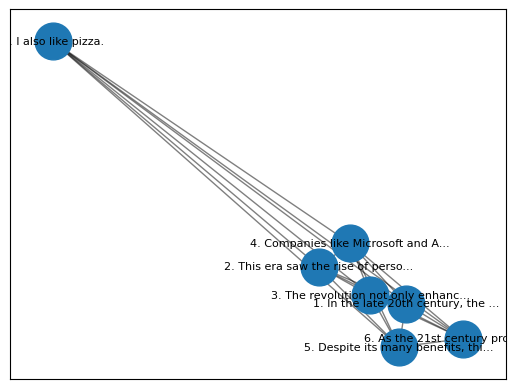

In [62]:
visualize_graph(graph, sentences)

In [63]:
scores = nx.pagerank(graph, weight='weight')
scores

{0: 0.18559130552258585,
 1: 0.16632627262234811,
 2: 0.157541519404492,
 3: 0.1466745933477058,
 4: 0.16268708377420732,
 5: 0.1711029613958671,
 6: 0.010076263932793606}

In [64]:
def extract_summary(sentences, scores, top_n=5):
    ranked_sentences = sorted(
        ( (scores[i], s) for i, s in enumerate(sentences) ),
        reverse=True
    )
    summary = ' '.join([sent for _, sent in ranked_sentences[:top_n]])
    return summary

In [65]:
print(extract_summary(sentences, scores, top_n=2))

In the late 20th century, the digital revolution transformed industries and societies, reshaping how people communicate, work, and consume media. As the 21st century progresses, addressing these issues remains crucial to ensuring the digital revolution benefits all segments of society.


### Out of the Box Implementation

In [38]:
def sumy_summarize(text, summary_length=2, type="textrank"):

    parser = PlaintextParser.from_string(text, Tokenizer("english"))

    # select which summarizer to you
    if type.lower() == "lexrank":
        summarizer = LexRankSummarizer()
    elif type.lower() == "textrank":
        summarizer = TextRankSummarizer()
    elif type.lower() == "luhn":
        summarizer = LuhnSummarizer()
    else:
        raise ValueError("Unsupported summarizer type. Choose 'luhn', 'lexrank', or 'textrank'.")

    summary = summarizer(parser.document, summary_length)

    return " ".join([str(sentence) for sentence in summary])

In [40]:
text = """\
In the late 20th century, the digital revolution transformed industries and societies, reshaping how people communicate, work, and consume media. This era saw the rise of personal computers, the internet, and mobile technology, each contributing to a more interconnected global community. The revolution not only enhanced data accessibility but also spurred significant innovations in software and hardware development. Companies like Microsoft and Apple became household names, driving forward technological advancements and changing everyday life. Despite its many benefits, this transformation also brought challenges, including privacy concerns and a digital divide that left certain populations behind. As the 21st century progresses, addressing these issues remains crucial to ensuring the digital revolution benefits all segments of society."""

In [41]:
summarizer.summarize(text)

'As the 21st century progresses, addressing these issues remains crucial to ensuring the digital revolution benefits all segments of society.'

In [42]:
sumy_summarize(text)

'In the late 20th century, the digital revolution transformed industries and societies, reshaping how people communicate, work, and consume media. This era saw the rise of personal computers, the internet, and mobile technology, each contributing to a more interconnected global community.'

In [43]:
text = """\
Advancements in renewable energy technologies have accelerated over the past decade, particularly in solar and wind energy sectors. These technologies are now more cost-effective and efficient, making them competitive with traditional fossil fuels. Governments and private sectors worldwide are increasingly investing in these clean energy sources to reduce carbon    emissions and combat climate change.

Despite the progress, the transition to renewable energy is not without challenges. The primary obstacles include the intermittency of wind and solar power, the need for substantial infrastructure investments, and resistance from industries reliant on fossil fuels. Overcoming these hurdles is essential for a sustainable energy future, requiring innovative solutions and persistent policy support."""

In [44]:
summarizer.summarize(text)

'Advancements in renewable energy technologies have accelerated over the past decade, particularly in solar and wind energy sectors.'

In [45]:
sumy_summarize(text)

'Advancements in renewable energy technologies have accelerated over the past decade, particularly in solar and wind energy sectors. The primary obstacles include the intermittency of wind and solar power, the need for substantial infrastructure investments, and resistance from industries reliant on fossil fuels.'

In [17]:
text = """\
Natural Language Processing (NLP) is a dynamic field of artificial intelligence that focuses on enabling machines to understand and interact with human language. It combines computational linguistics—rule-based modeling of human language—with statistical, machine learning, and deep learning models. These technologies allow for a range of applications, from speech recognition and translation to sentiment analysis and chatbots, revolutionizing how humans interact with machines and process large amounts of data efficiently and effectively."""

In [18]:
summarizer.summarize(text, ratio=0.5)

'Natural Language Processing (NLP) is a dynamic field of artificial intelligence that focuses on enabling machines to understand and interact with human language.'

In [19]:
sumy_summarize(text)

'Natural Language Processing (NLP) is a dynamic field of artificial intelligence that focuses on enabling machines to understand and interact with human language. These technologies allow for a range of applications, from speech recognition and translation to sentiment analysis and chatbots, revolutionizing how humans interact with machines and process large amounts of data efficiently and effectively.'